## Experiment Notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Train student from scratch without Teacher



### Load data

In [4]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224, 224)),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:13<00:00, 12583486.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Hyperparameters
batch_size = 128
learning_rate = 0.1


In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_loader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Load ResNet18 Student model

In [8]:
student = models.resnet18()

In [9]:
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)

In [10]:
for param in student.parameters():
    param.requires_grad = True

### Train Student without teacher

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [ ]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    student.train()

    # Train
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()



[1] train_loss: 1.625, train_accuracy: 42.69 %
[1] test_loss: 1.621, test_accuracy: 42.41 %
[2] train_loss: 1.335, train_accuracy: 51.32 %
[2] test_loss: 1.338, test_accuracy: 50.79 %
[3] train_loss: 1.309, train_accuracy: 53.16 %
[3] test_loss: 1.336, test_accuracy: 51.80 %
[4] train_loss: 1.041, train_accuracy: 62.62 %
[4] test_loss: 1.056, test_accuracy: 62.38 %
[5] train_loss: 0.928, train_accuracy: 67.26 %
[5] test_loss: 0.973, test_accuracy: 65.51 %
[6] train_loss: 1.007, train_accuracy: 65.19 %
[6] test_loss: 1.062, test_accuracy: 63.49 %
[7] train_loss: 0.918, train_accuracy: 68.18 %
[7] test_loss: 0.982, test_accuracy: 66.44 %
[8] train_loss: 0.728, train_accuracy: 74.54 %
[8] test_loss: 0.797, test_accuracy: 72.25 %
[9] train_loss: 0.686, train_accuracy: 76.55 %
[9] test_loss: 0.772, test_accuracy: 73.95 %
[10] train_loss: 0.719, train_accuracy: 75.12 %
[10] test_loss: 0.790, test_accuracy: 72.70 %
[11] train_loss: 0.643, train_accuracy: 77.60 %
[11] test_loss: 0.728, test_ac

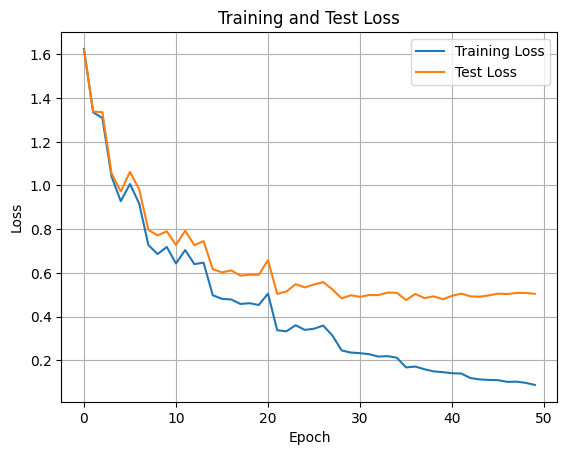

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

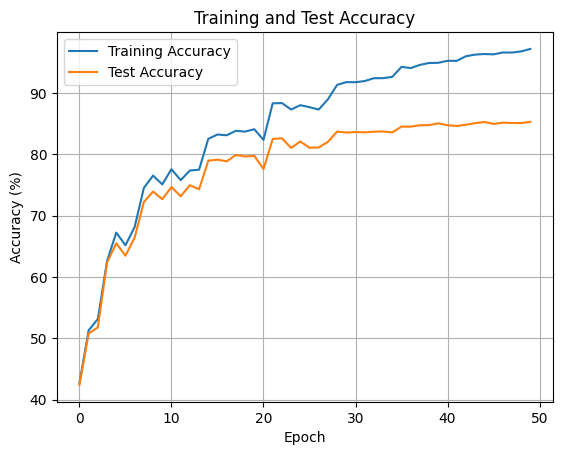

In [ ]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.grid()
plt.show()

In [ ]:
torch.save(student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/resnet18_student_non_learning.pth")

Mounted at /content/drive


## Train student with Teacher

In [23]:
# Hyperparameters
learning_rate = 0.1
batch_size = 128
T = 3
soft_target_loss_weight = 0.6

In [24]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# transform_train_student = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ])

transform_teacher = transforms.Compose([
        transforms.Resize(224),
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [25]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset_val = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [26]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_val = DataLoader(train_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
student = models.resnet18()
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)
for param in student.parameters():
    param.requires_grad = True

In [28]:
teacher = models.resnet50()
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/teacher_finetuned_cifar10_v2.pth'))
teacher = teacher.to(device)

In [29]:
criterion = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

In [11]:
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      # soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
      # soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

      # soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)
      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      loss = soft_target_loss_weight * soft_targets_loss + (1 - soft_target_loss_weight) * label_loss
      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

[1] train_loss: 1.401, train_accuracy: 49.90 %
[1] test_loss: 1.406, test_accuracy: 50.10 %
[2] train_loss: 1.350, train_accuracy: 57.78 %
[2] test_loss: 1.378, test_accuracy: 57.24 %
[3] train_loss: 1.093, train_accuracy: 63.26 %
[3] test_loss: 1.155, test_accuracy: 62.19 %
[4] train_loss: 0.926, train_accuracy: 68.78 %
[4] test_loss: 0.982, test_accuracy: 67.68 %
[5] train_loss: 0.879, train_accuracy: 71.34 %
[5] test_loss: 0.952, test_accuracy: 70.15 %
[6] train_loss: 0.838, train_accuracy: 71.88 %
[6] test_loss: 0.919, test_accuracy: 69.70 %
[7] train_loss: 0.757, train_accuracy: 74.63 %
[7] test_loss: 0.830, test_accuracy: 72.47 %
[8] train_loss: 0.659, train_accuracy: 78.44 %
[8] test_loss: 0.762, test_accuracy: 75.69 %
[9] train_loss: 0.683, train_accuracy: 77.93 %
[9] test_loss: 0.781, test_accuracy: 75.57 %
[10] train_loss: 0.626, train_accuracy: 79.35 %
[10] test_loss: 0.728, test_accuracy: 76.80 %
[11] train_loss: 0.663, train_accuracy: 78.12 %
[11] test_loss: 0.773, test_ac

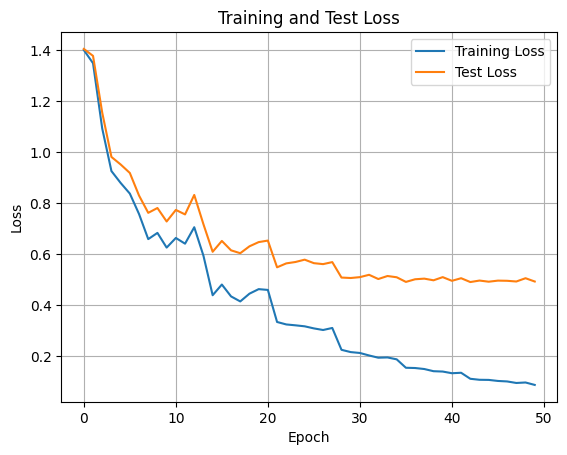

In [12]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.show()

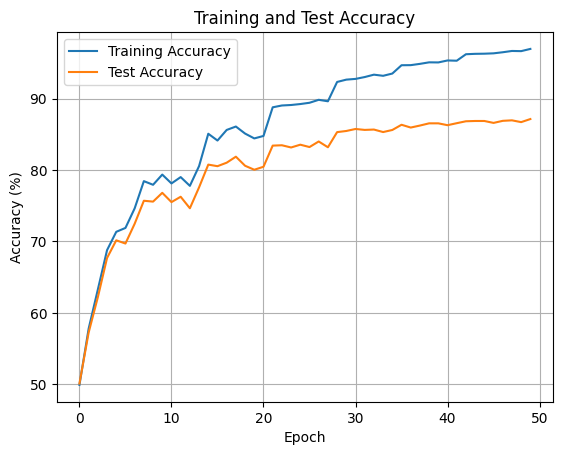

In [13]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.grid()
plt.show()

In [14]:
torch.save(student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/resnet18_student_learning.pth")

In [11]:
# archive - previous run with T=2 and soft target loss weight = 0.3
num_epochs = 50
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

teacher.eval()

for epoch in range(num_epochs):
    student.train()

    for i, data in enumerate(train_loader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      with torch.no_grad():
        teacher_inputs = transform_teacher(inputs)
        teacher_inputs = teacher_inputs.to(device)
        teacher_logits = teacher(teacher_inputs)

      student_logits = student(inputs)

      # soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
      # soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

      # soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)
      soft_targets_loss = criterion_kd(torch.log_softmax(student_logits / T, dim=1),
                               torch.softmax(teacher_logits / T, dim=1))
      label_loss = criterion(student_logits, labels)

      loss = soft_target_loss_weight * soft_targets_loss + (1 - soft_target_loss_weight) * label_loss
      loss.backward()
      optimizer.step()

    # Evaluate
    # on training data without augment
    student.eval()
    current_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
      for data in train_loader_val:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # on testing data
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = student(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()

[1] train_loss: 1.521, train_accuracy: 44.20 %
[1] test_loss: 1.514, test_accuracy: 44.40 %
[2] train_loss: 1.250, train_accuracy: 54.94 %
[2] test_loss: 1.260, test_accuracy: 53.94 %
[3] train_loss: 1.093, train_accuracy: 60.85 %
[3] test_loss: 1.124, test_accuracy: 60.00 %
[4] train_loss: 1.020, train_accuracy: 64.03 %
[4] test_loss: 1.042, test_accuracy: 63.59 %
[5] train_loss: 0.917, train_accuracy: 67.77 %
[5] test_loss: 0.959, test_accuracy: 66.20 %
[6] train_loss: 1.038, train_accuracy: 65.15 %
[6] test_loss: 1.089, test_accuracy: 64.84 %
[7] train_loss: 0.856, train_accuracy: 70.62 %
[7] test_loss: 0.905, test_accuracy: 69.52 %
[8] train_loss: 0.661, train_accuracy: 77.25 %
[8] test_loss: 0.740, test_accuracy: 74.60 %
[9] train_loss: 0.667, train_accuracy: 77.36 %
[9] test_loss: 0.761, test_accuracy: 75.03 %
[10] train_loss: 0.643, train_accuracy: 77.77 %
[10] test_loss: 0.729, test_accuracy: 75.09 %
[11] train_loss: 0.687, train_accuracy: 76.63 %
[11] test_loss: 0.780, test_ac